## 例4. 自己符号化器

In [1]:
using Base: @kwdef
using LinearAlgebra, Random, PyPlot, ProgressMeter, Statistics
using MLDatasets
include("../codes/neural_networks.jl")
rc("axes.spines", top=false, right=false)

In [2]:
trainset = MNIST(:train)
X_train, _ = trainset[:]; # return all observations
println("X_train: $(size(X_train))")

# training data
n_traindata = length(trainset)
n_batch = 200 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)

X_train = Matrix(reshape(X_train[:, :, 1:n_traindata], (:, n_traindata))');

X_train: (28, 28, 60000)


モデルを定義する．

In [11]:
model = MLP([28^2, 128, 2, 128, 28^2], [Tanh(), Identity(), Tanh(), Sigmoid()]; init_type="Xavier")
loss_fn = binary_crossentropy!

n_epoch = 50; # number of epoch
lr = 1e-3  # learning rate
weight_decay = 1e-3 # weight decay (L2 norm) strength
optimizer = Adam(lr=lr);

In [12]:
train_loss = zeros(n_epoch); #training loss of each epoch
for epoch in 1:n_epoch
    # learning rate schedule
    if epoch % 10 == 0
        optimizer.lr *= 0.5
    end

    # shuffling data
    shuffle_indices = shuffle(1:n_traindata)
    X_train = X_train[shuffle_indices, :];

    # update
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x = X_train[idx, :]
        loss = train_step!(model, x, x, loss_fn, optimizer=optimizer, weight_decay=weight_decay)
        train_loss[epoch] += loss
    end
    train_loss[epoch] /= n_traindata
    println("[$(lpad(epoch, ndigits(n_epoch), '0'))/$(n_epoch)] train loss: $(train_loss[epoch])")
end

[01/50] train loss: 0.9497335136181058
[02/50] train loss: 0.8750291530876347
[03/50] train loss: 0.8562340431806552
[04/50] train loss: 0.8401403573733751
[05/50] train loss: 0.8256871547209479
[06/50] train loss: 0.813782125961145
[07/50] train loss: 0.8044963547955379
[08/50] train loss: 0.7974503820096043
[09/50] train loss: 0.7909836672262064
[10/50] train loss: 0.7764158918489144
[11/50] train loss: 0.7725391937442544
[12/50] train loss: 0.7692993689533006
[13/50] train loss: 0.7665765971912852
[14/50] train loss: 0.7644205371672578
[15/50] train loss: 0.7624689056696295
[16/50] train loss: 0.7602904669549253
[17/50] train loss: 0.7584571815304666
[18/50] train loss: 0.7565985277764878
[19/50] train loss: 0.7551619979364943
[20/50] train loss: 0.750332540503539
[21/50] train loss: 0.7491523914229805
[22/50] train loss: 0.7482778704024067
[23/50] train loss: 0.747366208584489
[24/50] train loss: 0.7464028846820541
[25/50] train loss: 0.7455888096109103
[26/50] train loss: 0.744832

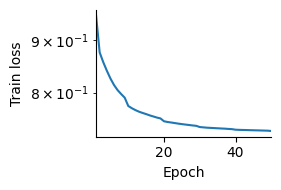

In [13]:
figure(figsize=(3,2))
semilogy(1:n_epoch, train_loss)
ylabel("Train loss"); xlabel("Epoch"); xlim(1, n_epoch)
tight_layout()

学習に使用しなかったデータを用いて，モデルの性能を確認しよう．

In [36]:
testset = MNIST(:test)
X_test, y_test = testset[:]

x_test = Matrix(reshape(X_test, (28^2, :))')
x_pred = model(x_test); # prediction (label probabilities)
println(size(y_pred))

(10000, 784)


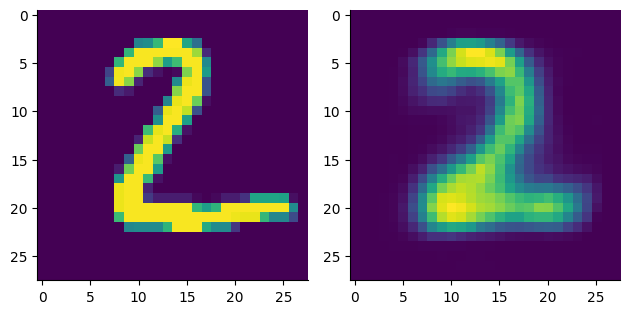

In [37]:
fig, axes = subplots(1, 2)
img_idx = 2
axes[1].imshow(reshape(x_test[img_idx, :], (28, 28))')
axes[2].imshow(reshape(x_pred[img_idx, :], (28, 28))')
tight_layout()

In [16]:
embed = model.z[3];

In [17]:
size(embed)

(10000, 2)

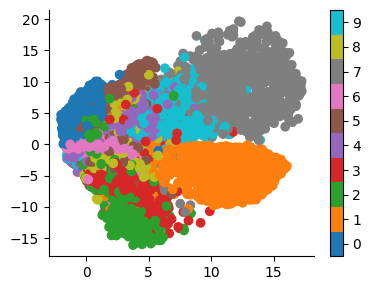

In [18]:
figure(figsize=(4,3))
sc = scatter(embed[:, 1], embed[:, 2], c=y_test, alpha=1, cmap="tab10", vmin=-0.5, vmax=9.5)
colorbar(sc, ticks=0:9)
tight_layout()

In [19]:
# forward computation of MLP
function forward_midlayers!(mlp::MLP, x; begin_idx=3)
    (;L, f, W, b, z) = mlp
    z[begin_idx] = x # input (n_batch x n_neurons)
    for l in begin_idx:L
        z[l+1] = f[l](z[l] * W[l].v .+ b[l].v) # hidden layers
    end
    return z[L+1] # output
end

forward_midlayers! (generic function with 1 method)

In [20]:
a = hcat([embed[1, :] * (1 - alpha) + alpha * embed[2, :] for alpha in 0:0.1:1]...)'

11×2 adjoint(::Matrix{Float64}) with eltype Float64:
 14.9057    12.2546
 13.8115     9.64901
 12.7174     7.04342
 11.6233     4.43783
 10.5292     1.83223
  9.43508   -0.773356
  8.34096   -3.37895
  7.24684   -5.98454
  6.15272   -8.59013
  5.0586   -11.1957
  3.96448  -13.8013

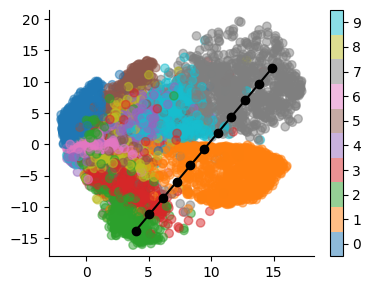

In [33]:
figure(figsize=(4,3), dpi=100)
sc = scatter(embed[:, 1], embed[:, 2], c=y_test, alpha=0.5, cmap="tab10", vmin=-0.5, vmax=9.5)
colorbar(sc, ticks=0:9)
plot(a[:, 1], a[:, 2], "o-", color="k", alpha=1)

tight_layout()

In [35]:
out_interp = forward_midlayers!(model, a, begin_idx=3)

11×784 Matrix{Float64}:
 5.32748e-8   4.54734e-8   7.20862e-8   …  5.79968e-8   6.95081e-8
 3.42996e-9   2.76853e-9   4.38454e-9      3.39363e-9   4.19415e-9
 1.19891e-10  9.55821e-11  1.47106e-10     9.09302e-11  1.42658e-10
 5.95226e-12  4.76133e-12  7.19174e-12     4.38205e-12  5.44619e-12
 2.95174e-13  2.40558e-13  3.5346e-13      2.21356e-13  2.43168e-13
 1.49941e-14  1.25451e-14  1.74155e-14  …  1.16107e-14  1.26775e-14
 9.07442e-15  5.99727e-15  8.49089e-15     6.30974e-15  7.77474e-15
 6.10529e-14  4.54649e-14  6.601e-14       3.35031e-14  5.67945e-14
 2.65338e-12  2.17175e-12  3.51004e-12     2.1795e-12   2.23203e-12
 5.62059e-10  5.18146e-10  6.00648e-10     4.96406e-10  5.84286e-10
 4.06154e-7   4.04636e-7   4.36343e-7   …  4.02344e-7   4.31555e-7

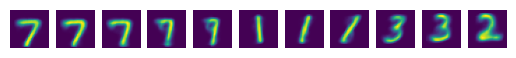

In [34]:
for i in 1:11
    subplot(1, 11, i)
    imshow(reshape(out[i, :], (28, 28))')
    axis("off")
end